# Deep Q-Learning Applied to Algorithmic Trading

<a href="https://www.kaggle.com/addarm/unsupervised-learning-as-signals-for-pairs-trading" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

INTRO


This deep learning network was inspired by the paper:
```BibTeX
@article{theate2021application,
  title={An application of deep reinforcement learning to algorithmic trading},
  author={Th{\'e}ate, Thibaut and Ernst, Damien},
  journal={Expert Systems with Applications},
  volume={173},
  pages={114632},
  year={2021},
  publisher={Elsevier}
}
```

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'
if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install scikit-learn
    %pip install tensorflow
    %pip install tqdm
    %pip install matplotlib
    %pip install python-dotenv
    %pip install yfinance
    %pip install pyarrow
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

    DATA_DIR = "/kaggle/input/DATASET"
else:
    DATA_DIR = "./data/"
    print('Running Local...')

import numpy as np
import yfinance as yf
import pandas as pd
from datetime import datetime
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import skew, kurtosis
import pyarrow as pa
import pyarrow.parquet as pq

os.getcwd()

Running Local...


'/mnt/c/Users/adamd/workspace/deep-reinforced-learning'

In [2]:
START_DATE = "2017-01-01"
SPLIT_DATE = '2018-1-1' # Turning point from train to tst
END_DATE = "2019-12-31" # pd.Timestamp(datetime.now() - BDay(1)).strftime('%Y-%m-%d')
DATA_DIR = "./data"
INDEX = "Date"
TICKER_SYMBOLS = [
    'DIA',  # Dow Jones
    'SPY',  # S&P 500
    'QQQ',  # NASDAQ 100
    'EZU',  # FTSE 100
    'EWJ',  # Nikkei 225
    'GOOGL',  # Google
    'AAPL',  # Apple
    'META',  # Facebook
    'AMZN',  # Amazon
    'MSFT',  # Microsoft
    'NOK',  # Nokia
    'PHIA.AS',  # Philips
    'SIE.DE',  # Siemens
    'BIDU',  # Baidu
    'BABA',  # Alibaba
    '0700.HK',  # Tencent
    '6758.T',  # Sony
    'JPM',  # JPMorgan Chase
    'HSBC',  # HSBC
    '0939.HK',  # CCB
    'XOM',  # ExxonMobil
    'TSLA',  # Tesla
    'VOW3.DE',  # Volkswagen
    '7203.T',  # Toyota
    'KO',  # Coca Cola
    'ABI.BR',  # AB InBev
    '2503.T',  # Kirin
]
TICKER_SYMBOLS = ['TSLA']
TARGET = 'TSLA'
INTERVAL = "1d"

CAPITAL = 1000
STATE_LEN = 30
FEES = 0.1 / 100
FEATURES = 4 # 4 dims: HLOC
OBS_SPACE = (STATE_LEN)*FEATURES
ACT_SPACE = 2
EPISODES = 50

# Financial Data

In [3]:
def get_tickerdata(tickers_symbols, start=START_DATE, end=END_DATE, interval=INTERVAL, datadir=DATA_DIR):
    tickers = {}
    earliest_end= datetime.strptime(end,'%Y-%m-%d')
    latest_start = datetime.strptime(start,'%Y-%m-%d')
    os.makedirs(DATA_DIR, exist_ok=True)
    for symbol in tickers_symbols:
        cached_file_path = f"{datadir}/{symbol}-{start}-{end}-{interval}.csv"

        try:
            if os.path.exists(cached_file_path):
                df = pd.read_parquet(cached_file_path)
                df.index = pd.to_datetime(df.index)
                assert len(df) > 0
            else:
                df = yf.download(
                    symbol,
                    start=START_DATE,
                    end=END_DATE,
                    progress=False,
                    interval=INTERVAL,
                )
                assert len(df) > 0
                df.to_parquet(cached_file_path, index=True, compression="snappy")
            min_date = df.index.min()
            max_date = df.index.max()
            nan_count = df["Close"].isnull().sum()
            skewness = round(skew(df["Close"].dropna()), 2)
            kurt = round(kurtosis(df["Close"].dropna()), 2)
            outliers_count = (df["Close"] > df["Close"].mean() + (3 * df["Close"].std())).sum()
            print(
                f"{symbol} => min_date: {min_date}, max_date: {max_date}, kurt:{kurt}, skewness:{skewness}, outliers_count:{outliers_count},  nan_count: {nan_count}"
            )
            tickers[symbol] = df

            if min_date > latest_start:
                latest_start = min_date
            if max_date < earliest_end:
                earliest_end = max_date
        except Exception as e:
            print(f"Error with {symbol}: {e}")

    return tickers, latest_start, earliest_end

tickers, latest_start, earliest_end = get_tickerdata(TICKER_SYMBOLS)
tickers[TARGET]

TSLA => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:-0.56, skewness:-0.28, outliers_count:0,  nan_count: 0


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,14.324000,14.688667,14.064000,14.466000,14.466000,88849500
2017-01-04,14.316667,15.200000,14.287333,15.132667,15.132667,168202500
2017-01-05,15.094667,15.165333,14.796667,15.116667,15.116667,88675500
2017-01-06,15.128667,15.354000,15.030000,15.267333,15.267333,82918500
2017-01-09,15.264667,15.461333,15.200000,15.418667,15.418667,59692500
...,...,...,...,...,...,...
2019-12-23,27.452000,28.134001,27.333332,27.948000,27.948000,199794000
2019-12-24,27.890667,28.364668,27.512667,28.350000,28.350000,120820500
2019-12-26,28.527332,28.898666,28.423332,28.729334,28.729334,159508500


# Trading Environment

In [4]:
from tf_agents.environments import py_environment, utils
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts
import numpy as np

ACT_LONG = 1
ACT_SHORT = -1
ACT_HOLD = 0


class TradingEnv(py_environment.PyEnvironment):
    """
    A custom trading environment for reinforcement learning, compatible with tf_agents.

    This environment simulates a simple trading scenario where an agent can take one of three actions:
    - Long (buy), Short (sell), or Hold a financial instrument, aiming to maximize profit through trading decisions.

    Parameters:
    - data: DataFrame containing the stock market data.
    - data_dim: Dimension of the data to be used for each observation.
    - money: Initial capital to start trading.
    - stateLength: Number of past observations to consider for the state.
    - transactionCosts: Costs associated with trading actions.
    """

    def __init__(self, data, data_dim, money, stateLength, transactionCosts):
        super(TradingEnv, self).__init__()
        self.data = self.preprocess_data(data)
        self.data_dim = data_dim
        self.min_balance = -money//4
        self.initial_balance = money
        self.state_length = stateLength
        self.transaction_cost = transactionCosts
        self._episode_ended = False

        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=ACT_SHORT, maximum=ACT_LONG, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(shape=(self.state_length, self.data_dim), dtype=np.float32, name='observation')

        self.reset()

    def preprocess_data(self, df):
        log_returns = np.log(df / df.shift(1))
        normalized_data = (log_returns - log_returns.mean()) / log_returns.std()
        normalized_data.dropna(inplace=True)
        return normalized_data

    def action_spec(self):
        """Provides the specification of the action space."""
        return self._action_spec

    def observation_spec(self):
        """Provides the specification of the observation space."""
        return self._observation_spec

    def _reset(self):
        """Resets the environment state and prepares for a new episode."""
        self.balance = self.initial_balance
        self.position = 0
        self.total_shares = 0
        self.current_step = self.state_length
        self._episode_ended = False
        initial_observation = self._next_observation()
        return ts.restart(initial_observation)

    def _next_observation(self):
        """Generates the next observation based on the current step."""
        if self.current_step + self.state_length > len(self.data):
            padding_rows_needed = max(len(self.data) - (self.current_step + self.state_length), 0)
            frame = self.data.iloc[-self.state_length:] if padding_rows_needed == 0 else self.data.iloc[-padding_rows_needed:]
            padding = np.zeros((padding_rows_needed, self.data_dim))
            obs = np.vstack((padding, frame[['Close', 'Low', 'High', 'Volume']].values))
        else:
            frame = self.data.iloc[self.current_step-self.state_length:self.current_step]
            obs = frame[['Close', 'Low', 'High', 'Volume']].values

        obs = np.array(obs, dtype=np.float32)

        return obs

    def _step(self, action):
        """Executes a trading action and returns the new state of the environment."""
        if self._episode_ended:
            return self.reset()

        current_price = self.data.iloc[self.current_step]['Close']
        self.current_step += 1

        reward = 0

        if action == ACT_SHORT or action == ACT_LONG:
            if self.total_shares > 0:
                self.balance += self.total_shares * current_price * (1 - self.transaction_cost)
                reward = self.balance - self.initial_balance
                self.total_shares = 0

        if action == ACT_LONG:
            self.position = 1
            self.total_shares = self.balance // (current_price * (1 + self.transaction_cost))
            self.balance -= self.total_shares * current_price * (1 + self.transaction_cost)
        elif action == ACT_SHORT:
            self.position = -1

        if self.balance < self.min_balance:
            # bankrupt
            done = True
            reward = -1
        else:
            done = self.current_step >= len(self.data)
        reward = np.clip(reward, -1, 1)
        if done:
            self._episode_ended = True
            return ts.termination(self._next_observation(), reward)
        else:
            return ts.transition(self._next_observation(), reward, discount=1.0)

    def render(self, mode='human'):
        """Outputs the current state of the environment for visualization."""
        print(f'Step: {self.current_step}, Balance: {self.balance}')

environment = TradingEnv(tickers[TARGET], FEATURES, CAPITAL, STATE_LEN, FEES)
utils.validate_py_environment(environment, episodes=5)

2024-03-08 21:01:59.475488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 21:01:59.475540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 21:01:59.476542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 21:01:59.482487: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 21:02:00.397353: W tensorflow/compiler/tf2

In [5]:
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment

tf_env = tf_py_environment.TFPyEnvironment(environment)

print(isinstance(tf_env, tf_environment.TFEnvironment))
print("TimeStep Specs:", tf_env.time_step_spec())
print("Action Specs:", tf_env.action_spec())

True
TimeStep Specs: TimeStep(
{'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(30, 4), dtype=tf.float32, name='observation', minimum=array(-3.4028235e+38, dtype=float32), maximum=array(3.4028235e+38, dtype=float32))})
Action Specs: BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(-1, dtype=int32), maximum=array(1, dtype=int32))


# Deep Q-Network Architecure

## Architecture

2 models:
- Policy Model: This is the primary model that the agent uses to make decisions or select actions based on the current state of the environment. The policy model is actively trained and updated throughout the training process based on the agent's experiences. In real-life applications, after the training phase is complete, the policy model is what gets deployed to make decisions or take actions in the given environment.
- Target Model: The target model is used exclusively during the training phase to provide a stable target for the temporal difference (TD) error calculation, which is crucial for the stability of the Q-learning updates. The target model's weights are periodically synchronized with the policy model's weights but at a much slower rate. This delayed update helps to stabilize the learning process by making the target for the policy updates more consistent across training batches. The target model itself is not used for decision-making or action selection outside of the training context.

Some notes on this 2 model arch:
- Stability/Reducing Temporal Correlations: The agent learns a policy that maps states to actions by using a Q-function. This Q-function estimates the rewards by taking a certain action in a given state. The learning process continuously updates the Q-values based on new experiences. If the Q-function is constantly changing—as it would be when updates are made based on estimates from the same function—it can lead to unstable training dynamics. The estimates can become overly optimistic, and the learning process can diverge.
- Target: The target network is a stable baseline for the policy network to compare against. While the policy network is frequently updated to reflect the latest learning, the target network's weights are updated less frequently. This slower update rate provides a fixed target for the policy network to aim for over multiple iterations, making the learning process more stable.

In practice, the policy network is responsible for selecting actions during training and gameplay. Its weights are regularly updated to reflect the agent's learning. The target network, on the other hand, is used to generate the Q-value targets for the updates of the policy network. Every few steps, the weights from the policy network are copied to the target network, ensuring the target for the updates remains relatively stable but still gradually adapts to the improved policy. The policy model is used both during training (for learning and decision-making) and after training (for decision-making in the deployment environment).

The target model is used during the training process only, to calculate stable target values for updating the policy model.
After training is complete and the model is deployed in a real-world application, only the policy model is used to make decisions or take actions based on the learned policy. The target model's role ends with the completion of the training phase, as its primary purpose is to aid in the convergence and stability of the training process itself.

## DRL Flow

- Initialization: init policy network and the target network with the same architecture but separate parameters.
- Data Preparation: Normalize input data using calculated coefficients to ensure consistency in scale.
- Learning Process:
    -At each training step, observe the current market state and process it through normalization.
    - Select an action using the epsilon-greedy policy (a balance between exploration and exploitation) based on the current state.
    - Execute the selected action in the simulated trading environment, observe the next state, and receive a reward based on the action's outcome.
    - Store the experience (current state, action, reward, next state) in the replay memory.
    - Sample a random batch of past experiences from the replay memory for learning to reduce correlation between consecutive learning steps.
    - Use the policy network to predict Q-values for the current states and the target network to calculate the target Q-values for the next states.
    - Update the policy network by minimizing the difference between its Q-value predictions and the target Q-values using backpropagation.
    - Every few steps, update the target network's parameters with the policy network's parameters to gradually adapt the learning target.
- Evaluation and Adjustment: Periodically test the trained policy network on a separate validation set or environment to evaluate performance.
    -Repeat the learning and evaluation process for many episodes until the policy network stabilizes and performs satisfactorily.
- Application Phase
    - Model Deployment: Deploy the trained policy network in a real-world environment or a simulation that closely mimics real trading conditions.
    - Real-time Operation: Observe the current market state and process it (normalization, etc.) as done during training.
    - Use the trained policy network to select the action that maximizes expected rewards based on the current market state, leaning towards exploitation of the learned policy over exploration. Execute the selected action in the market (buy, sell, hold).
- Continuous Learning:
    - Repeat the learning process with new market data and experiences, possibly in a less frequent, offline manner.
    - Update the policy and target networks as new data becomes available and as the market evolves to maintain or improve performance over time.

In [6]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from collections import deque
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQNModel(Sequential):
    def __init__(self, observation_space, action_space, learning_rate=0.0001, l2_reg=0.01, neurons=32, dropout=0.2, n_layers=5, activation=LeakyReLU(alpha=0.01), kernel_initializer=glorot_uniform(), loss=Huber()):
        super().__init__()

        self.add(Dense(neurons, activation=activation, input_shape=(observation_space,), kernel_regularizer=l2(l2_reg), kernel_initializer=kernel_initializer))

        for _ in range(1, n_layers):
            self.add(Dense(neurons, activation=activation, kernel_regularizer=l2(l2_reg), kernel_initializer=kernel_initializer))
            self.add(BatchNormalization())
            self.add(Dropout(dropout))

        self.add(Dense(action_space, activation='linear', kernel_initializer=kernel_initializer))

        self.optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)
        self.compile(loss=loss, optimizer=self.optimizer)


class DQNAgent:
    def __init__(self, observation_space, action_space, replay_memory_size=10000, batch_size=64, gamma=0.99, epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.995, learning_rate=0.001, target_update_iter=1000):
        self.action_space = action_space
        self.memory = ReplayMemory(replay_memory_size)
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_iter = target_update_iter
        self.iteration = 0

        self.policy_model = DQNModel(observation_space, action_space, learning_rate)
        self.target_model = DQNModel(observation_space, action_space, learning_rate)
        self.target_model.set_weights(self.policy_model.get_weights())

        self.callbacks = [
            EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True),
            ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose=1)
        ]

        self.loss_history = []
        self.rewards_history = []
        self.total_rewards_history = []
        self.epsilon_history = []
        self.action_history = []

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        self.action_history.append(action)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        state = np.array(state).flatten()[None, :]

        q_values = self.policy_model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return 0  # No update if not enough memory

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert lists to numpy arrays for processing
        states = np.array([s.flatten() for s in states])
        next_states = np.array([ns.flatten() for ns in next_states])
        rewards = np.array(rewards)  # Assume rewards are already clipped or don't need clipping
        dones = np.array(dones)
        actions = np.array(actions)

        # Predict the Q values of next states
        next_q_values = self.target_model.predict(next_states, verbose=0)

        # Compute the maximum q-value for each next state
        max_next_q_values = np.max(next_q_values, axis=1)

        # Compute the target q values
        targets = rewards + (1 - dones) * self.gamma * max_next_q_values
        q_values = self.policy_model.predict(states, verbose=0)


        for i, action in enumerate(actions):
            q_values[i, action] = targets[i]

        history = self.policy_model.fit(states, q_values, batch_size=self.batch_size, verbose=0, callbacks=self.callbacks)
        loss = history.history['loss'][0]

        self.loss_history.append(loss)
        self.total_rewards_history.append(np.sum(self.rewards_history))
        self.epsilon_history.append(self.epsilon)
        self.rewards_history = []  # Reset rewards history for the next episode

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        # Periodically update the target model's weights
        self.iteration += 1
        if self.iteration % self.target_update_iter == 0:
            self.update_target_model()

        return loss

    def reset_episode_stats(self):
        self.total_reward = 0
        self.total_loss = 0
        self.episode_steps = 0


    def adapt_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def update_target_model(self):
        self.target_model.set_weights(self.policy_model.get_weights())

    def save_model(self, file_name):
        self.policy_model.save(file_name)

    def load_model(self, file_name):
        self.policy_model = load_model(file_name)
        self.target_model.set_weights(self.policy_model.get_weights())

    def plot_history(self):
        # Plotting loss history
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 3, 1)
        plt.plot(self.loss_history)
        plt.title('Loss History')
        plt.xlabel('Episode')
        plt.ylabel('Loss')

        # Plotting rewards history
        plt.subplot(1, 3, 2)
        plt.plot(self.total_rewards_history)
        plt.title('Total Rewards History')
        plt.xlabel('Episode')
        plt.ylabel('Total Rewards')

        # Plotting epsilon history
        plt.subplot(1, 3, 3)
        plt.plot(self.epsilon_history)
        plt.title('Epsilon Decay')
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')

        plt.tight_layout()
        plt.show()

Num GPUs Available:  1


2024-03-08 21:02:04.266452: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-08 21:02:04.302662: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-08 21:02:04.302731: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# Trading Operations

In [7]:
class TradingSimulator:
    def __init__(self, env, agent, episodes, checkpoint_interval):
        self.env = env
        self.agent = agent
        self.episodes = episodes
        self.checkpoint_interval = checkpoint_interval

    def train(self):
        self.episode_rewards = []
        self.episode_losses = []
        for episode in tqdm(range(0, self.episodes + 1), desc="Training"):
            self.agent.reset_episode_stats()
            time_step = self.env.reset()
            state = time_step.observation
            done = time_step.is_last()
            total_reward = 0
            total_loss = 0

            while not done:
                action = self.agent.act(state)
                time_step = self.env.step(action)
                next_state = time_step.observation
                reward = time_step.reward
                done = time_step.is_last()

                self.agent.remember(state, action, reward, next_state, done)
                if done and self.env.balance < self.env.min_balance:
                    print(f"Episode {episode+1} terminated early due to low balance.")
                loss = self.agent.replay()

                state = next_state
                total_reward += reward
                total_loss += loss

            avg_loss = total_loss / episode if episode > 0 else 0
            self.episode_rewards.append(total_reward)
            self.episode_losses.append(avg_loss)

            if episode > 0 and episode % self.checkpoint_interval == 0:
                self.agent.save_model(f'dqn_model_checkpoint_{episode}.h5')
                print(f"\nCheckpoint saved at episode {episode}")

            print(f'\nEpisode {episode}: Total Reward: {total_reward}, Avg Loss: {avg_loss:.4f}, Epsilon: {self.agent.epsilon:.4f}')

            if episode > 0 and episode % self.agent.target_update_iter == 0:
                self.agent.update_target_model()

        print(f'\nTraining completed. Mean Reward: {np.mean(self.episode_rewards):.4f}, Mean Loss: {np.mean(self.episode_losses):.4f}')

    def validate(self):
        total_rewards = []
        for episode in tqdm(range(1, self.episodes + 1), desc="Validation"):
            self.agent.reset_episode_stats()
            time_step = self.env.reset()
            state = time_step.observation
            done = time_step.is_last()
            total_reward = 0

            while not done:
                action = self.agent.act(state)
                time_step = self.env.step(action)
                next_state = time_step.observation
                reward = time_step.reward
                done = time_step.is_last()

                state = next_state
                total_reward += reward

            total_rewards.append(total_reward)
            print(f'\nValidation Episode: {episode}, Total Reward: {total_reward}')

        avg_reward = np.mean(total_rewards)
        print(f'\nAverage Reward Over Validation Episodes: {avg_reward:.4f}')


    def plot_performance(self):
        """
        Plot the training performance including rewards and losses.
        """
        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Total Reward', color=color)
        ax1.plot(self.episode_rewards, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:blue'
        ax2.set_ylabel('Average Loss', color=color)
        ax2.plot(self.episode_losses, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.title('Training Performance')
        plt.show()


In [8]:
stock= tickers[TARGET]
train_data = stock[stock.index < pd.to_datetime(SPLIT_DATE)].copy()
test_data = stock[stock.index >= pd.to_datetime(SPLIT_DATE)].copy()

agent = DQNAgent(observation_space=STATE_LEN * FEATURES, action_space=ACT_SPACE)

env = TradingEnv(data=train_data, data_dim=FEATURES, money=CAPITAL, stateLength=STATE_LEN, transactionCosts=FEES)
simulator = TradingSimulator(env, agent, episodes=40, checkpoint_interval=1000)
simulator.train()

2024-03-08 21:02:04.345662: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-08 21:02:04.345892: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-08 21:02:04.346022: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-08 21:02:04.545551: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-08 21:02:04.545625: I external/local_xla/xla/stream_executor


Episode 0: Total Reward: -50.0, Avg Loss: 0.0000, Epsilon: 0.4552


Training:   5%|▍         | 2/41 [01:31<30:27, 46.85s/it]


Episode 1: Total Reward: -16.0, Avg Loss: 250.9832, Epsilon: 0.1511


Training:   7%|▋         | 3/41 [02:24<31:39, 50.00s/it]


Episode 2: Total Reward: -6.0, Avg Loss: 67.0780, Epsilon: 0.0502


Training:  10%|▉         | 4/41 [03:28<34:03, 55.24s/it]


Episode 3: Total Reward: 0.0, Avg Loss: 22.5179, Epsilon: 0.0167


Training:  12%|█▏        | 5/41 [04:36<36:03, 60.10s/it]


Episode 4: Total Reward: -1.0, Avg Loss: 8.3804, Epsilon: 0.0100


Training:  15%|█▍        | 6/41 [05:48<37:18, 63.97s/it]


Episode 5: Total Reward: 0.0, Avg Loss: 2.9636, Epsilon: 0.0100


Training:  17%|█▋        | 7/41 [06:56<36:59, 65.27s/it]


Episode 6: Total Reward: 0.0, Avg Loss: 1.3929, Epsilon: 0.0100


Training:  20%|█▉        | 8/41 [08:06<36:45, 66.83s/it]


Episode 7: Total Reward: 0.0, Avg Loss: 0.7521, Epsilon: 0.0100


Training:  22%|██▏       | 9/41 [09:14<35:54, 67.32s/it]


Episode 8: Total Reward: 0.0, Avg Loss: 0.3428, Epsilon: 0.0100


Training:  24%|██▍       | 10/41 [10:33<36:30, 70.68s/it]


Episode 9: Total Reward: -47.0, Avg Loss: 88.0778, Epsilon: 0.0100


Training:  27%|██▋       | 11/41 [11:28<33:02, 66.09s/it]


Episode 10: Total Reward: -3.0, Avg Loss: 90.4321, Epsilon: 0.0100


Training:  29%|██▉       | 12/41 [12:29<31:12, 64.56s/it]


Episode 11: Total Reward: -91.0, Avg Loss: 332.1638, Epsilon: 0.0100


Training:  32%|███▏      | 13/41 [13:29<29:23, 62.98s/it]


Episode 12: Total Reward: -55.0, Avg Loss: 63.4914, Epsilon: 0.0100


Training:  34%|███▍      | 14/41 [14:38<29:13, 64.93s/it]


Episode 13: Total Reward: -2.0, Avg Loss: 16.2746, Epsilon: 0.0100


Training:  37%|███▋      | 15/41 [15:42<28:01, 64.68s/it]


Episode 14: Total Reward: 0.0, Avg Loss: 8.5451, Epsilon: 0.0100


Training:  39%|███▉      | 16/41 [16:43<26:29, 63.59s/it]


Episode 15: Total Reward: 0.0, Avg Loss: 4.5562, Epsilon: 0.0100


Training:  41%|████▏     | 17/41 [17:37<24:12, 60.51s/it]


Episode 16: Total Reward: -1.0, Avg Loss: 3.8053, Epsilon: 0.0100


Training:  44%|████▍     | 18/41 [18:33<22:44, 59.33s/it]


Episode 17: Total Reward: -1.0, Avg Loss: 3.6724, Epsilon: 0.0100


Training:  46%|████▋     | 19/41 [19:27<21:07, 57.60s/it]


Episode 18: Total Reward: 0.0, Avg Loss: 2.2690, Epsilon: 0.0100


Training:  49%|████▉     | 20/41 [20:26<20:22, 58.22s/it]


Episode 19: Total Reward: 0.0, Avg Loss: 2.2954, Epsilon: 0.0100


Training:  51%|█████     | 21/41 [21:21<19:01, 57.08s/it]


Episode 20: Total Reward: -100.0, Avg Loss: 3.8713, Epsilon: 0.0100


Training:  54%|█████▎    | 22/41 [22:20<18:16, 57.70s/it]


Episode 21: Total Reward: -104.0, Avg Loss: 5.5280, Epsilon: 0.0100


Training:  56%|█████▌    | 23/41 [23:17<17:12, 57.37s/it]


Episode 22: Total Reward: -101.0, Avg Loss: 7.4688, Epsilon: 0.0100


Training:  59%|█████▊    | 24/41 [24:16<16:26, 58.02s/it]


Episode 23: Total Reward: -104.0, Avg Loss: 6.5385, Epsilon: 0.0100


Training:  61%|██████    | 25/41 [25:14<15:27, 57.96s/it]


Episode 24: Total Reward: -89.0, Avg Loss: 1.7167, Epsilon: 0.0100


Training:  63%|██████▎   | 26/41 [26:13<14:32, 58.17s/it]


Episode 25: Total Reward: -10.0, Avg Loss: 0.6316, Epsilon: 0.0100


Training:  66%|██████▌   | 27/41 [27:11<13:35, 58.23s/it]


Episode 26: Total Reward: 0.0, Avg Loss: 0.5119, Epsilon: 0.0100


Training:  68%|██████▊   | 28/41 [28:09<12:35, 58.11s/it]


Episode 27: Total Reward: -1.0, Avg Loss: 0.4447, Epsilon: 0.0100


Training:  71%|███████   | 29/41 [29:07<11:37, 58.16s/it]


Episode 28: Total Reward: 0.0, Avg Loss: 0.3787, Epsilon: 0.0100


Training:  73%|███████▎  | 30/41 [30:05<10:39, 58.10s/it]


Episode 29: Total Reward: -1.0, Avg Loss: 0.3189, Epsilon: 0.0100


Training:  76%|███████▌  | 31/41 [31:04<09:42, 58.28s/it]


Episode 30: Total Reward: 0.0, Avg Loss: 0.2982, Epsilon: 0.0100


Training:  78%|███████▊  | 32/41 [32:01<08:40, 57.83s/it]


Episode 31: Total Reward: 0.0, Avg Loss: 0.2676, Epsilon: 0.0100


Training:  80%|████████  | 33/41 [32:59<07:45, 58.15s/it]


Episode 32: Total Reward: 0.0, Avg Loss: 0.2437, Epsilon: 0.0100


Training:  83%|████████▎ | 34/41 [33:56<06:44, 57.74s/it]


Episode 33: Total Reward: 0.0, Avg Loss: 0.2261, Epsilon: 0.0100


Training:  85%|████████▌ | 35/41 [34:55<05:47, 57.92s/it]


Episode 34: Total Reward: 0.0, Avg Loss: 0.2240, Epsilon: 0.0100


Training:  88%|████████▊ | 36/41 [35:51<04:46, 57.33s/it]


Episode 35: Total Reward: -2.0, Avg Loss: 0.2093, Epsilon: 0.0100


Training:  90%|█████████ | 37/41 [36:50<03:52, 58.02s/it]


Episode 36: Total Reward: 0.0, Avg Loss: 0.1854, Epsilon: 0.0100


Training:  93%|█████████▎| 38/41 [37:45<02:51, 57.13s/it]


Episode 37: Total Reward: 0.0, Avg Loss: 0.1772, Epsilon: 0.0100


Training:  95%|█████████▌| 39/41 [38:44<01:55, 57.68s/it]


Episode 38: Total Reward: 0.0, Avg Loss: 0.1947, Epsilon: 0.0100


Training:  98%|█████████▊| 40/41 [39:39<00:56, 56.91s/it]


Episode 39: Total Reward: 0.0, Avg Loss: 0.1594, Epsilon: 0.0100


Training: 100%|██████████| 41/41 [40:40<00:00, 59.52s/it]


Episode 40: Total Reward: 0.0, Avg Loss: 0.1489, Epsilon: 0.0100

Training completed. Mean Reward: -19.1463, Mean Loss: 24.3838


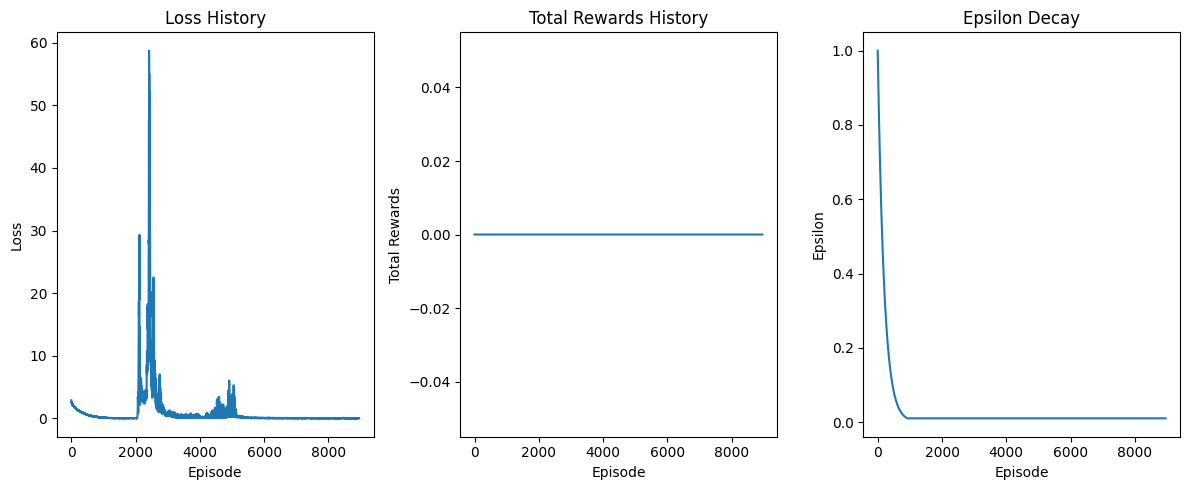

In [9]:
agent.plot_history()

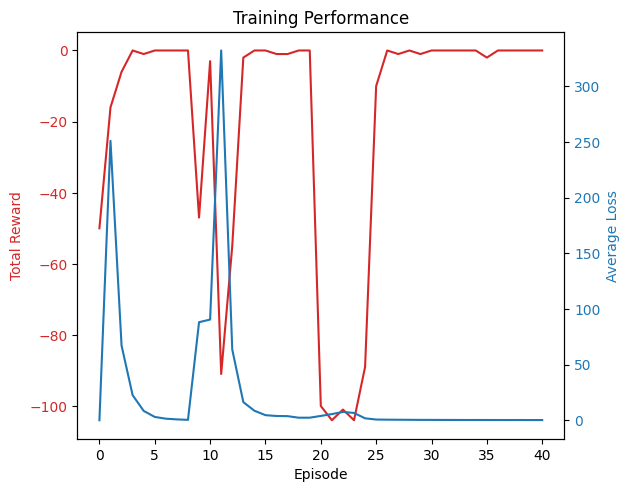

In [10]:
simulator.plot_performance()

In [11]:
env = TradingEnv(data=test_data, data_dim=FEATURES, money=CAPITAL, stateLength=STATE_LEN, transactionCosts=FEES)
simulator = TradingSimulator(env, agent, episodes=15, checkpoint_interval=1000)
simulator.validate()

Validation:   7%|▋         | 1/15 [00:25<05:51, 25.09s/it]


Validation Episode: 1, Total Reward: -2.0


Validation:  13%|█▎        | 2/15 [00:53<05:54, 27.26s/it]


Validation Episode: 2, Total Reward: 0.0


Validation:  20%|██        | 3/15 [01:28<06:06, 30.58s/it]


Validation Episode: 3, Total Reward: 1.0


Validation:  27%|██▋       | 4/15 [01:55<05:20, 29.16s/it]


Validation Episode: 4, Total Reward: 0.0


Validation:  33%|███▎      | 5/15 [02:22<04:44, 28.46s/it]


Validation Episode: 5, Total Reward: -2.0


Validation:  40%|████      | 6/15 [02:57<04:36, 30.69s/it]


Validation Episode: 6, Total Reward: 0.0


Validation:  47%|████▋     | 7/15 [03:29<04:08, 31.07s/it]


Validation Episode: 7, Total Reward: -1.0


Validation:  53%|█████▎    | 8/15 [03:59<03:36, 30.88s/it]


Validation Episode: 8, Total Reward: -1.0


Validation:  60%|██████    | 9/15 [04:36<03:16, 32.78s/it]


Validation Episode: 9, Total Reward: 0.0


Validation:  67%|██████▋   | 10/15 [05:09<02:42, 32.58s/it]


Validation Episode: 10, Total Reward: 0.0


# Conclusion

CONCLUDE

## References

- [TensorFlow Agents](https://www.tensorflow.org/agents/overview)
- [Open Gym AI Github](https://github.com/openai/gym)
- [Greg et al, OpenAI Gym, (2016)](https://arxiv.org/abs/1606.01540)
- [Théate, Thibaut, and Damien Ernst. "An application of deep reinforcement learning to algorithmic trading." Expert Systems with Applications 173 (2021): 114632.](https://www.sciencedirect.com/science/article/pii/S0957417421000737)
- [Remote development in WSL](https://code.visualstudio.com/docs/remote/wsl-tutorial)
- [NVIDIA Driver Downloads](https://www.nvidia.com/Download/index.aspx)
- [CUDA Toolkit](https://developer.nvidia.com/cuda-toolkit-archive)
- [TensorRT for CUDA](https://docs.nvidia.com/deeplearning/tensorrt/archives/index.html#trt_7)

## Github

Article here is also available on [Github](https://github.com/adamd1985/pairs_trading_unsupervised_learning)

Kaggle notebook available [here](https://www.kaggle.com/code/addarm/unsupervised-learning-as-signals-for-pairs-trading)

## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.